### I'm taking advice that I heard from multiple sources recently when it comes to learning coding and machine learning. That is, I'm going to type out all the code myself, after getting familiar with it. It will help me with understanding the methods, as well as with muscle memory, if you will. 

This notebook will follow chapter 2 of Sebastian Raschka's book _Python Machine Learning_, particularly the Perceptron and Adaline models. 

In [1]:
import numpy as np
class Perceptron(object):
    '''Perceptron Classifier
    Parameters
    __________
    
    eta : float
        learning rate (between 0.0 and 1.0)
    n_iter : int
        number of passes over the data set
    
    Attributes
    __________
    
    w_ : 1d-array
        weights after fitting
    errors_ : list
        number of misclassifications in each epoch
    '''
    def __init__(self, eta=0.01, n_iter=10, random_seed=19):
        self.eta = eta
        self.n_iter = n_iter
        self.random_seed = random_seed
    def fit(self, X, y):
        '''fit training data
        Parameters
        __________
        
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like, shape = n_samples
            training labels (target values)
        
        Returns
        _______
        
        self : object
        '''
        rgen = np.random.RandomState(self.random_seed)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return errors
    def net_input(self, X):
        '''Calculate net input'''
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        '''Return class label after unit step'''
        return np.where(self.net_input(X) >= 0.0, 1, -1)

#### Whew! That was a handful! I'm going to take a dinner break. After that, I'll review the above to make sure I understand what's going on.

In [2]:
import pandas as pd
df = pd.read_csv('data/iris.data', header=None)
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [3]:
import matplotlib.pyplot as plt

We have loaded the famous iris data set into a pandas data frame, df. Now we're going to take the column that describes the iris type and convert (or encode) those labels to integer values. 

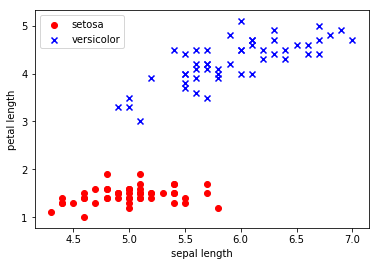

In [23]:
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)
X = df.iloc[0:100, [0,2]].values #extract first and third feature columns and assign to our feature matrix
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='versicolor')
plt.xlabel('sepal length')
plt.ylabel('petal length')
plt.legend(loc='upper left')
plt.show()

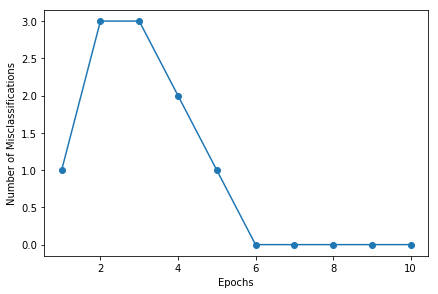

In [24]:
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.tight_layout()
plt.xlabel('Epochs')
plt.ylabel('Number of Misclassifications')
plt.show()

In [25]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    #setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), 
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    #plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1], 
                    alpha=0.8, c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx],
                    label=cl)

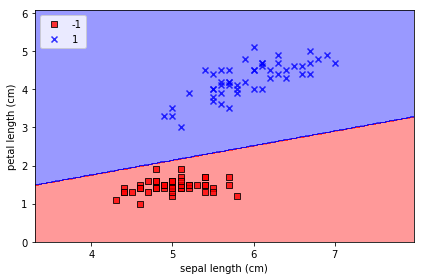

In [26]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length (cm)')
plt.ylabel('petal length (cm)')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### So there is a Perceptron model. I had to figure out a bug in my code. the data labels (y) had a capital "I" for "Iris", and I used a lower case "I". It goes to show how often something like that can trip up a program. 

### The book goes on to demonstrate an adaline gradient descent model, but I'm going to skip past that to the adaline with stochastic gradient descent, in the interest of time and space (ha!)

In [27]:
from numpy.random import seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    cost_ : list
        Sum-of-squares cost function value averaged over all
        training samples in each epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X,y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
    def partial_fit(self, X, y):
        '''Fit training data without reinitializing the weights'''
        if not self.w_initialized: 
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X,y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        '''shuffle training data'''
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        '''initialize weights to zeros'''
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        '''Apply Adaline learning rule to update the weights'''
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] = self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        '''Calculate net input'''
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        '''Compute linear activation'''
        return self.net_input(X)
    
    def predict(self, X):
        '''Return class label after unit step'''
        return np.where(self.activation(X) >= 0.0, 1, -1)

### So above is the Adaline Stochastic Gradient Descent class. Time to actually run it using our data. Let's see how it goes.

In [29]:
#Standardize the data
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

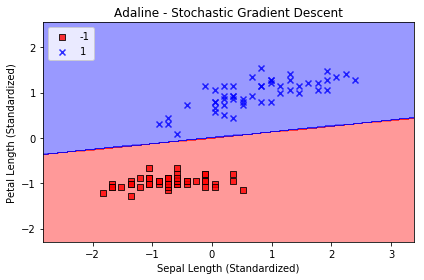

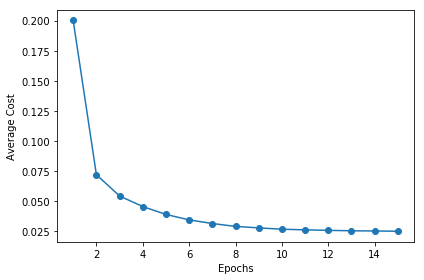

In [30]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('Sepal Length (Standardized)')
plt.ylabel('Petal Length (Standardized)')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
plt.show()

### Bingo, bango, bongo! That went off without a hitch. Look at that nice convergence on the cost chart. 

In [31]:
ada.partial_fit(X_std[0, :], y[0])

In [32]:
# not sure what the above was, but it was the last line of code for this chapter. 